# <h1 style="text-align: center; color:magenta"> Prediction Section </h1>

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## <h2 style="text-align: left; color:cyan"> Loading Data </h2>

Load data from the prepared file

In [235]:
df = pd.read_pickle("prediction_features_df.pkl")

## <h2 style="text-align: left; color:cyan"> Preprocessing & Feature Engineering </h2>
Some features such as member count, transport insurance and vehicle expenses and mean_age of the family, living in urban/rural neighborhood were created in the previous secion, i.e. the sheet loading section.

In [236]:
# Storing the info of the original dataframe
import io
buffer = io.StringIO()
df.info(buf=buffer)
info_lines = buffer.getvalue().splitlines()
original_info_df = (pd.DataFrame([x.split() for x in info_lines[5:-2]], columns=info_lines[3].split())
       .drop(["#",'Count'],axis=1)
       .rename(columns={'Non-Null':'Non-Null Count'})
       .astype({"Non-Null Count":int}))
original_info_df.sort_values(by="Non-Null Count", ascending=False)
del buffer, info_lines

In [237]:
original_info_df

,Column,Non-Null Count,Dtype
0,Address,151824,int64
1,Urban,151824,bool
2,Year,151824,int64
3,Fasl,151824,int64
4,khanevartype,151824,int64
5,province,151824,object
6,town,151824,int64
7,member_cnt,151824,int64
8,active_member_cnt,118166,float64
9,mean_age,151824,float64


### <h3 style="text-align: left; color:cyan"> Filling missing data </h3>

Our target column is "transportation_cost", so we will drop rows with said column being NaN.
We fill the NaN values of some features with few NaN count with zero, only the ones that make sense to do so, for features with many NaN values, we store their column names and decide later to be included in our model features or not.

In [238]:
df.dropna(subset=["transportation_cost"], inplace=True)


df.subsidy.fillna(0, inplace=True)
df.misc_income.fillna(0, inplace=True)
df.active_member_cnt.fillna(0, inplace=True)
df.communication_expenses.fillna(0, inplace=True)

# Tenure column has only 4 NaN values which we change to "other" value
df.tenure.fillna("other", inplace=True)

# columns with more than half of the data being null
df.netincome_w_y.fillna(0, inplace=True)
df.vehicle_expenses.fillna(0, inplace=True)
df.income_s_y.fillna(0, inplace=True)
df.transport_insurance_expenses.fillna(0, inplace=True)
df.highly_educated_member_cnt.fillna(0, inplace=True)
df.dining_expenses.fillna(0, inplace=True)

# We drop town column since it does not add any value to the model, towns with same number are considered as the same
df.drop(columns=["town"], inplace=True)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137600 entries, 0 to 151823
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Address                       137600 non-null  int64  
 1   Urban                         137600 non-null  bool   
 2   Year                          137600 non-null  int64  
 3   Fasl                          137600 non-null  int64  
 4   khanevartype                  137600 non-null  int64  
 5   province                      137600 non-null  object 
 6   member_cnt                    137600 non-null  int64  
 7   active_member_cnt             137600 non-null  float64
 8   mean_age                      137600 non-null  float64
 9   highly_educated_member_cnt    137600 non-null  float64
 10  tenure                        137600 non-null  object 
 11  vehicle                       137600 non-null  bool   
 12  motorcycle                    137600 non-nul

In [240]:
df["total_income"] = df.netincome_w_y + df.income_s_y + df.subsidy + df.misc_income
df = df.drop(columns=["netincome_w_y", "income_s_y", "subsidy", "misc_income"])

Since khanevartype has only two values (1,2) we convert it (0,1) by just subtracting 1 from it.
Then also convert it to Boolean, it reduces data volume in memory.

In [241]:
df['khanevartype'] = (df['khanevartype'] - 1)

Converting boolean columns to int

In [242]:
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)


In [243]:
duplicate_addresses = df.loc[df.Address.duplicated(), :].Address.unique().shape[0]

There are 36792 families with info being present in different years. there is no reason to group the result for those families and we treat them as separate data since we are going to drop the Address columns later on.

In [244]:
df = df[df.transportation_cost < 3e+08]

### <h3 style="text-align: left; color:cyan"> Splitting train, validation & test data </h4>

In [245]:
X_test = df.loc[(df.Fasl==4) & (df.Year==1401), :]
y_test = X_test.pop("transportation_cost")

X = df.loc[~df.index.isin(X_test.index), :]
y = X.pop("transportation_cost")

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 42, test_size = 0.25)


Investigation correlation of features with target variable

In [246]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, n_neighbors=3, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X.select_dtypes((int, float)), 
                            y)
mi_scores

Address                         0.214132
communication_expenses          0.208448
total_income                    0.173637
vehicle                         0.173281
transport_insurance_expenses    0.142708
vehicle_expenses                0.142104
Year                            0.063234
dining_expenses                 0.054451
member_cnt                      0.043970
mean_age                        0.042819
highly_educated_member_cnt      0.039435
active_member_cnt               0.034071
motorcycle                      0.013470
Urban                           0.004930
bicycle                         0.003953
Fasl                            0.002538
khanevartype                    0.000283
Name: MI Scores, dtype: float64

In [247]:
# khanevartype is not correlated with our target, so we drop them from df
# df = df.drop(columns=["khanevartype"])

In [248]:
less_correlated_feats = mi_scores[mi_scores<0.05].index.to_list()
less_correlated_feats

['member_cnt',
 'mean_age',
 'highly_educated_member_cnt',
 'active_member_cnt',
 'motorcycle',
 'Urban',
 'bicycle',
 'Fasl',
 'khanevartype']

### <h3 style="text-align: left; color:cyan"> Feature Scaling </h4>

In [249]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [250]:
categorical_columns = ["province", "tenure"]

In [251]:
excluded_cols = set(["Address"] + categorical_columns + less_correlated_feats)
excluded_cols = ["Address"] + ["Fasl", "khanevartype"] + categorical_columns 

In [252]:
province_enc = OneHotEncoder()
province_enc.fit(df[["province"]])
train_province = province_enc.transform(X_train[["province"]]).toarray()
val_province = province_enc.transform(X_val[["province"]]).toarray()
test_province = province_enc.transform(X_test[["province"]]).toarray()

In [253]:
tenure_enc = OneHotEncoder()
tenure_enc.fit(df[["tenure"]])
train_tenure = tenure_enc.transform(X_train[["tenure"]]).toarray()
val_tenure = tenure_enc.transform(X_val[["tenure"]]).toarray()
test_tenure = tenure_enc.transform(X_test[["tenure"]]).toarray()


In [254]:
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit(X_train.drop(excluded_cols, axis=1))

# The following 3 data do not contain categorical variables
# X_train.loc[:, X_train.drop(excluded_cols, axis=1).columns.to_list()] = min_max_scaler.transform(X_train.drop(excluded_cols, axis=1))
# X_val.loc[:, X_val.drop(excluded_cols, axis=1).columns.to_list()] = min_max_scaler.transform(X_val.drop(excluded_cols, axis=1))
# X_test.loc[:, X_test.drop(excluded_cols, axis=1).columns.to_list()] = min_max_scaler.transform(X_test.drop(excluded_cols, axis=1))
X_train_numeric = min_max_scaler.transform(X_train.drop(excluded_cols, axis=1))
X_val_numeric = min_max_scaler.transform(X_val.drop(excluded_cols, axis=1))
X_test_numeric = min_max_scaler.transform(X_test.drop(excluded_cols, axis=1))

In [255]:
# Features with categorical included
X_train_w_cat = np.hstack((train_province, train_tenure, X_train_numeric))
X_val_w_cat = np.hstack((val_province, val_tenure, X_val_numeric))
X_test_w_cat = np.hstack((test_province, test_tenure, X_test_numeric))

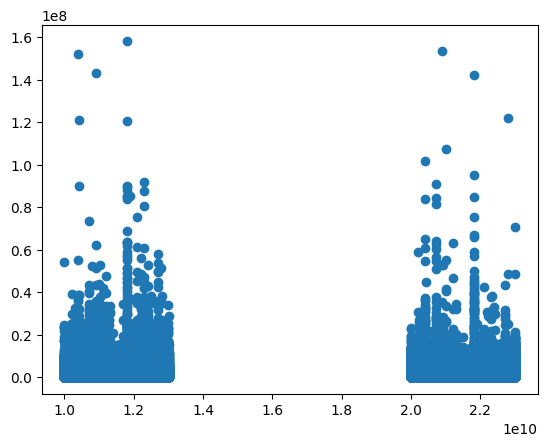

In [258]:
plt.scatter(df.Address, df.transportation_cost)

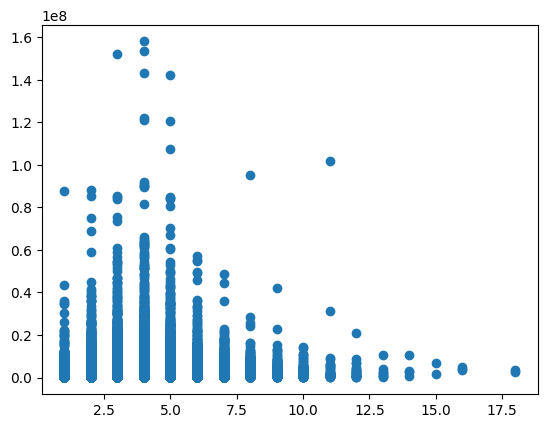

In [259]:
plt.scatter(df.member_cnt[df.index!=143648], df.transportation_cost[df.index!=143648])

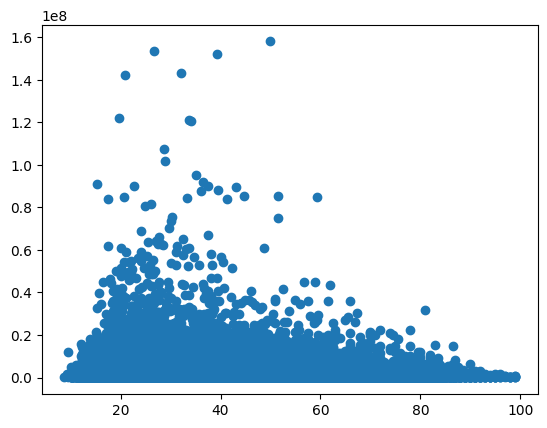

In [260]:
plt.scatter(df.mean_age, df.transportation_cost)

<Axes: >

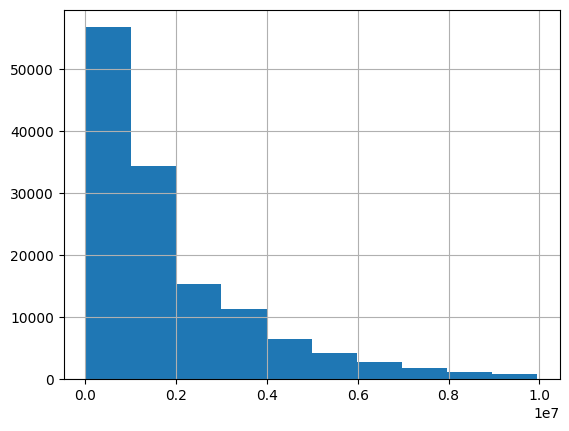

In [261]:
df.transportation_cost[df.transportation_cost<0.1e+08].hist()

In [262]:
criteria = 2e+08
print((y_train>criteria).sum())
print((y_val>criteria).sum())
print((y_test>criteria).sum())


0
0
0


## <h2 style="text-align: left; color:cyan"> Regression Models </h2>

In [263]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


### <h3 style="text-align: left; color:cyan"> Random Forest Regression Model - w/o categoricals </h3>

In [264]:
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_numeric, y_train)
y_pred = rf_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=rf_reg.predict(X_train_numeric)))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred))

Train data accuracy: 0.8878359920021744
Validation data accuracy: 0.18132720302098104


The above model is clearly not working well.

### <h3 style="text-align: left; color:cyan"> Multiple Linear Regression Model - w/o categoricals </h3>

In [265]:
poly_transformer = PolynomialFeatures(2, include_bias=True, interaction_only=True)
train_poly_features = poly_transformer.fit_transform(X_train_numeric)
val_poly_features = poly_transformer.transform(X_val_numeric)

model = LinearRegression()
model.fit(train_poly_features, y_train)

train_y_pred = model.predict(train_poly_features)
validate_y_pred = model.predict(val_poly_features)
train_r2 = r2_score(y_train, train_y_pred)
validation_r2 = r2_score(y_val, validate_y_pred)
print("train R2= ",train_r2, "\nvalidation R2= ",validation_r2, "\nR2 diff= ", train_r2 - validation_r2)

train R2=  0.22810469176956483 
validation R2=  0.21417201726061852 
R2 diff=  0.013932674508946308


### <h3 style="text-align: left; color:cyan"> Random Forest Regression Model - with categoricals </h3>

In [266]:
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf_reg.fit(X_train_w_cat, y_train)
y_pred_train = rf_reg.predict(X_train_w_cat)
y_pred_val = rf_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.8938959942438256
Validation data accuracy: 0.2117608526733219


### <h3 style="text-align: left; color:cyan"> Multiple Linear Regression Model - with categoricals </h3>

In [269]:
poly_transformer = PolynomialFeatures(1, include_bias=True, interaction_only=True)
train_poly_features = poly_transformer.fit_transform(X_train_w_cat)
val_poly_features = poly_transformer.transform(X_val_w_cat)

model = LinearRegression()
model.fit(train_poly_features, y_train)

train_y_pred = model.predict(train_poly_features)
validate_y_pred = model.predict(val_poly_features)
train_r2 = r2_score(y_train, train_y_pred)
validation_r2 = r2_score(y_val, validate_y_pred)
print("train R2= ",train_r2, "\nvalidation R2= ",validation_r2, "\nR2 diff= ", train_r2 - validation_r2)

train R2=  0.22975754382703617 
validation R2=  0.2163169362737113 
R2 diff=  0.01344060755332488


### <h3 style="text-align: left; color:cyan"> Hist GB Regression Model - w & w/o categoricals </h3>

In [277]:
hgb_reg = HistGradientBoostingRegressor(loss="squared_error",
                                        max_iter=3000,
                                        learning_rate=0.1,
                                        n_iter_no_change=30,
                                        random_state=42)
hgb_reg.fit(X_train_w_cat, y_train)
y_pred_train = hgb_reg.predict(X_train_w_cat)
y_pred_val = hgb_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.3990201086722559
Validation data accuracy: 0.2600819827460381


In [272]:
hgb_reg = HistGradientBoostingRegressor(loss="squared_error",
                                        max_iter=3000,
                                        learning_rate=0.05,
                                        n_iter_no_change=30,
                                        random_state=42)
hgb_reg.fit(X_train_numeric, y_train)
y_pred_train = hgb_reg.predict(X_train_numeric)
y_pred_val = hgb_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.32632500411705434
Validation data accuracy: 0.22746052246064707


### <h3 style="text-align: left; color:cyan"> SGD Regressor </h3>

In [278]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, loss='squared_error')
sgd_reg.fit(X_train_numeric, y_train)
y_pred_train = sgd_reg.predict(X_train_numeric)
y_pred_val = sgd_reg.predict(X_val_numeric)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.17608554943505772
Validation data accuracy: 0.1636155022280148


In [279]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, loss='squared_error')
sgd_reg.fit(X_train_w_cat, y_train)
y_pred_train = sgd_reg.predict(X_train_w_cat)
y_pred_val = sgd_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.20645668721914512
Validation data accuracy: 0.19040855136591095


### <h3 style="text-align: left; color:cyan"> Huber Regressor </h3>

In [280]:
from sklearn.linear_model import HuberRegressor
huber_reg = HuberRegressor(max_iter=1000, epsilon=1000)
huber_reg.fit(X_train_w_cat, y_train)
y_pred_train = huber_reg.predict(X_train_w_cat)
y_pred_val = huber_reg.predict(X_val_w_cat)
print("Train data accuracy:",r2_score(y_true = y_train, y_pred=y_pred_train))
print("Validation data accuracy:",r2_score(y_true = y_val, y_pred=y_pred_val))

Train data accuracy: 0.1948603899135759
Validation data accuracy: 0.18019677554471103
